In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
import numpy as np
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import pickle
import time
from imblearn.over_sampling import SMOTE


In [2]:
def preprocessing(df, feature_to_drop, target_feature, strategy_missing_values, missing_values):
    features = df
    try:
        features = features.drop(columns=feature_to_drop)
        features = features.drop(columns=target_feature)
    except Exception as e:
        print(e)
    target = df[target_feature]
    target = target.fillna(0)

    if strategy_missing_values == "zero":
        features = features.fillna(0)
        # imp = SimpleImputer(missing_values=missing_values, strategy='constant', fill_value=0)
        # features = imp.fit_transform(features)
    elif strategy_missing_values == "mean":
        imp = SimpleImputer(missing_values=missing_values, strategy='mean')
        features = imp.fit_transform(features)
    elif strategy_missing_values == "median":
        imp = SimpleImputer(missing_values=missing_values, strategy='median')
        features = imp.fit_transform(features)
    elif strategy_missing_values == "nan":
        features = features.fillna(missing_values)

    return features, target


In [3]:
def hyperparameter_optimization(pipeline, parameters, X_train, y_train, X_test, y_test, optimizer='grid_search', n_iter=None):
    start = time.time()

    # cv=KFold(n_splits=4)
    # cv = StratifiedKFold(n_splits=4, shuffle=True,
    #                      random_state=42).split(X_train, list(y_test))
    if optimizer == 'grid_search':
        grid_obj = GridSearchCV(estimator=pipeline,
                                param_grid=parameters,
                                refit=True,
                                #cv=cv,
                                return_train_score=False,
                                scoring='accuracy',
                                )
        grid_obj.fit(X_train, y_train, )

    elif optimizer == 'random_search':
        grid_obj = RandomizedSearchCV(estimator=pipeline,
                                      param_distributions=parameters,
                                      n_iter=n_iter,
                                      #cv=cv,
                                      refit=True,
                                      scoring='accuracy',
                                      return_train_score=False)
        grid_obj.fit(X_train, y_train, )

    elif optimizer == 'bayes_search':
        grid_obj = BayesSearchCV(
                                    estimator=pipeline,
                                    search_spaces=parameters,
                                    scoring='accuracy',
                                    # cv=cv,
                                    n_iter=n_iter,

        )
        grid_obj.fit(X_train, y_train, )
    else:
        print('enter search method')
        return

    estimator = grid_obj.best_estimator_
    # cvs = cross_val_score(estimator, X_train, y_train, cv=4)
    # result = pd.DataFrame(grid_obj.cv_results_)

    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    # print("Cross-validation Score Accuracy: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print(classification_report(y_test, estimator.predict(X_test), target_names=["0", "1", "2"]))

    print("Time elapsed: ", time.time() - start)
    cm = confusion_matrix(y_test, estimator.predict(X_test))
    disp = ConfusionMatrixDisplay(cm, display_labels=["0", "1", "2"])
    disp.plot()

    results=[grid_obj.best_score_,estimator.score(X_test, y_test),time.time() - start]#,result.shape[0]]
    return results, estimator


In [4]:
def print_decision_rules(rf, features_names):
    f = open("decision_path_forest_exp_v3.txt", "w")
    for tree_idx, est in enumerate(rf.estimators_):
        tree = est.tree_
        assert tree.value.shape[1] == 1  # no support for multi-output

        f.write('--------------\nTREE: {}\n'.format(tree_idx))

        iterator = enumerate(zip(
            tree.children_left, tree.children_right, tree.feature, tree.threshold, tree.value))
        for node_idx, data in iterator:
            left, right, feature, th, value = data

            # left: index of left child (if any)
            # right: index of right child (if any)
            # feature: index of the feature to check
            # th: the threshold to compare against
            # value: values associated with classes

            # for classifier, value is 0 except the index of the class to return
            class_idx = np.argmax(value[0])

            if left == -1 and right == -1:
                f.write('{} LEAF: return class={}\n'.format(
                    node_idx, class_idx))
            else:
                # f.write('{} NODE: if feature[{}] < {} then next={} else next={}\n'.format(node_idx, feature, th, left, right))
                f.write('{} NODE: if {} < {} then next={} else next={}\n'.format(
                    node_idx, features_names[feature], th, left, right))
    f.close()


def plot_feature_importances(clf, feature_names, filename):
    features_imp = []
    plt.figure(figsize=(80, 80))
    importances = clf.feature_importances_
    importances = importances[:30]
    indices = np.argsort(importances)
    plt.title('Feature Importances', fontsize=58)
    plt.barh(range(len(indices)),
             importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i]
                                     for i in indices], fontsize=48)
    plt.xlabel('Relative Importance', fontsize=24)
    plt.savefig(filename)

    for i in indices:
        if importances[i] != 0:
            features_imp.append(feature_names[i])

    return features_imp


In [5]:
data = pd.read_excel("dataset_3.xlsx")
missing_values = [" "]
target = 'cliff_top'
to_drop = ['transetto', 'Hs (m)']

In [6]:
# data.drop(columns=to_drop, inplace=True)
X, y = preprocessing(data, feature_to_drop=to_drop, target_feature=target,
                     strategy_missing_values="zero", missing_values=missing_values)
X

,H falesia (m) 2021,Pendenza falesia 2021 (°),esposizione (°) Nord falesia,UCS (MPa),GSI,Q-SLOPE,largezza spiaggia + talus2021 (m),pendenza spiaggia + talus 2021 (°),presenza di massi nel talus,erosione spiaggia 2008-2019 GIZC
0,12.0,44,20,30,55,0.0125,25,6,1.0,-1.00
1,15.0,51,20,30,55,0.0125,11,13,1.0,-1.00
2,16.0,58,20,30,55,0.0125,18,9,1.0,-1.00
3,21.0,80,20,30,55,0.0125,15,11,1.0,-1.00
4,16.0,45,20,30,55,0.0125,8,7,1.0,-1.00
...,...,...,...,...,...,...,...,...,...,...
305,24.0,62,110,15,40,0.0083,7,8,0.0,2.39
306,15.0,48,110,15,40,0.0083,10,9,0.0,2.39
307,10.0,42,110,15,40,0.0083,16,3,0.0,2.39
308,5.0,40,110,15,40,0.0083,23,2,0.0,2.39


In [7]:
features = list(X.columns)
features

['H falesia (m) 2021',
 'Pendenza falesia 2021 (°)',
 'esposizione (°) Nord falesia ',
 'UCS (MPa)',
 'GSI',
 'Q-SLOPE',
 'largezza spiaggia + talus2021 (m)',
 'pendenza spiaggia + talus 2021 (°)',
 'presenza di massi nel talus ',
 'erosione spiaggia 2008-2019 GIZC']

In [8]:
label = []
for i in y:
    if i <= -5:
        label.append(0)
    elif i > -5 and i <=5:
        label.append(1)
    else:
        label.append(2)


In [20]:
oversample = SMOTE()
# # # # transform the dataset
X, label = oversample.fit_resample(X, label)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.1)

In [23]:
c = 0
for i in y_test:
    if i == 2:
        c += 1
c
        

13

##### Results
Score best parameters:  0.8882505679974034
Best parameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test Score:  0.8409090909090909
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.87      0.72      0.79        18
           2       0.92      0.92      0.92        13

    accuracy                           0.84        44
   macro avg       0.85      0.86      0.85        44
weighted avg       0.85      0.84      0.84        44

Time elapsed:  331.1607458591461


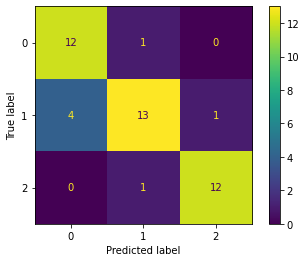

In [25]:
rf_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 5, 7, 9, 11, None],
    'max_features': ["log2", "sqrt"],
    'n_estimators': [100, 150, 200],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
}

clf = RandomForestClassifier()
res, est = hyperparameter_optimization(clf, rf_grid, X_train, y_train, X_test, y_test, 'grid_search')

with open('random_forest.pickle', 'wb') as handle:
    pickle.dump(est, handle)


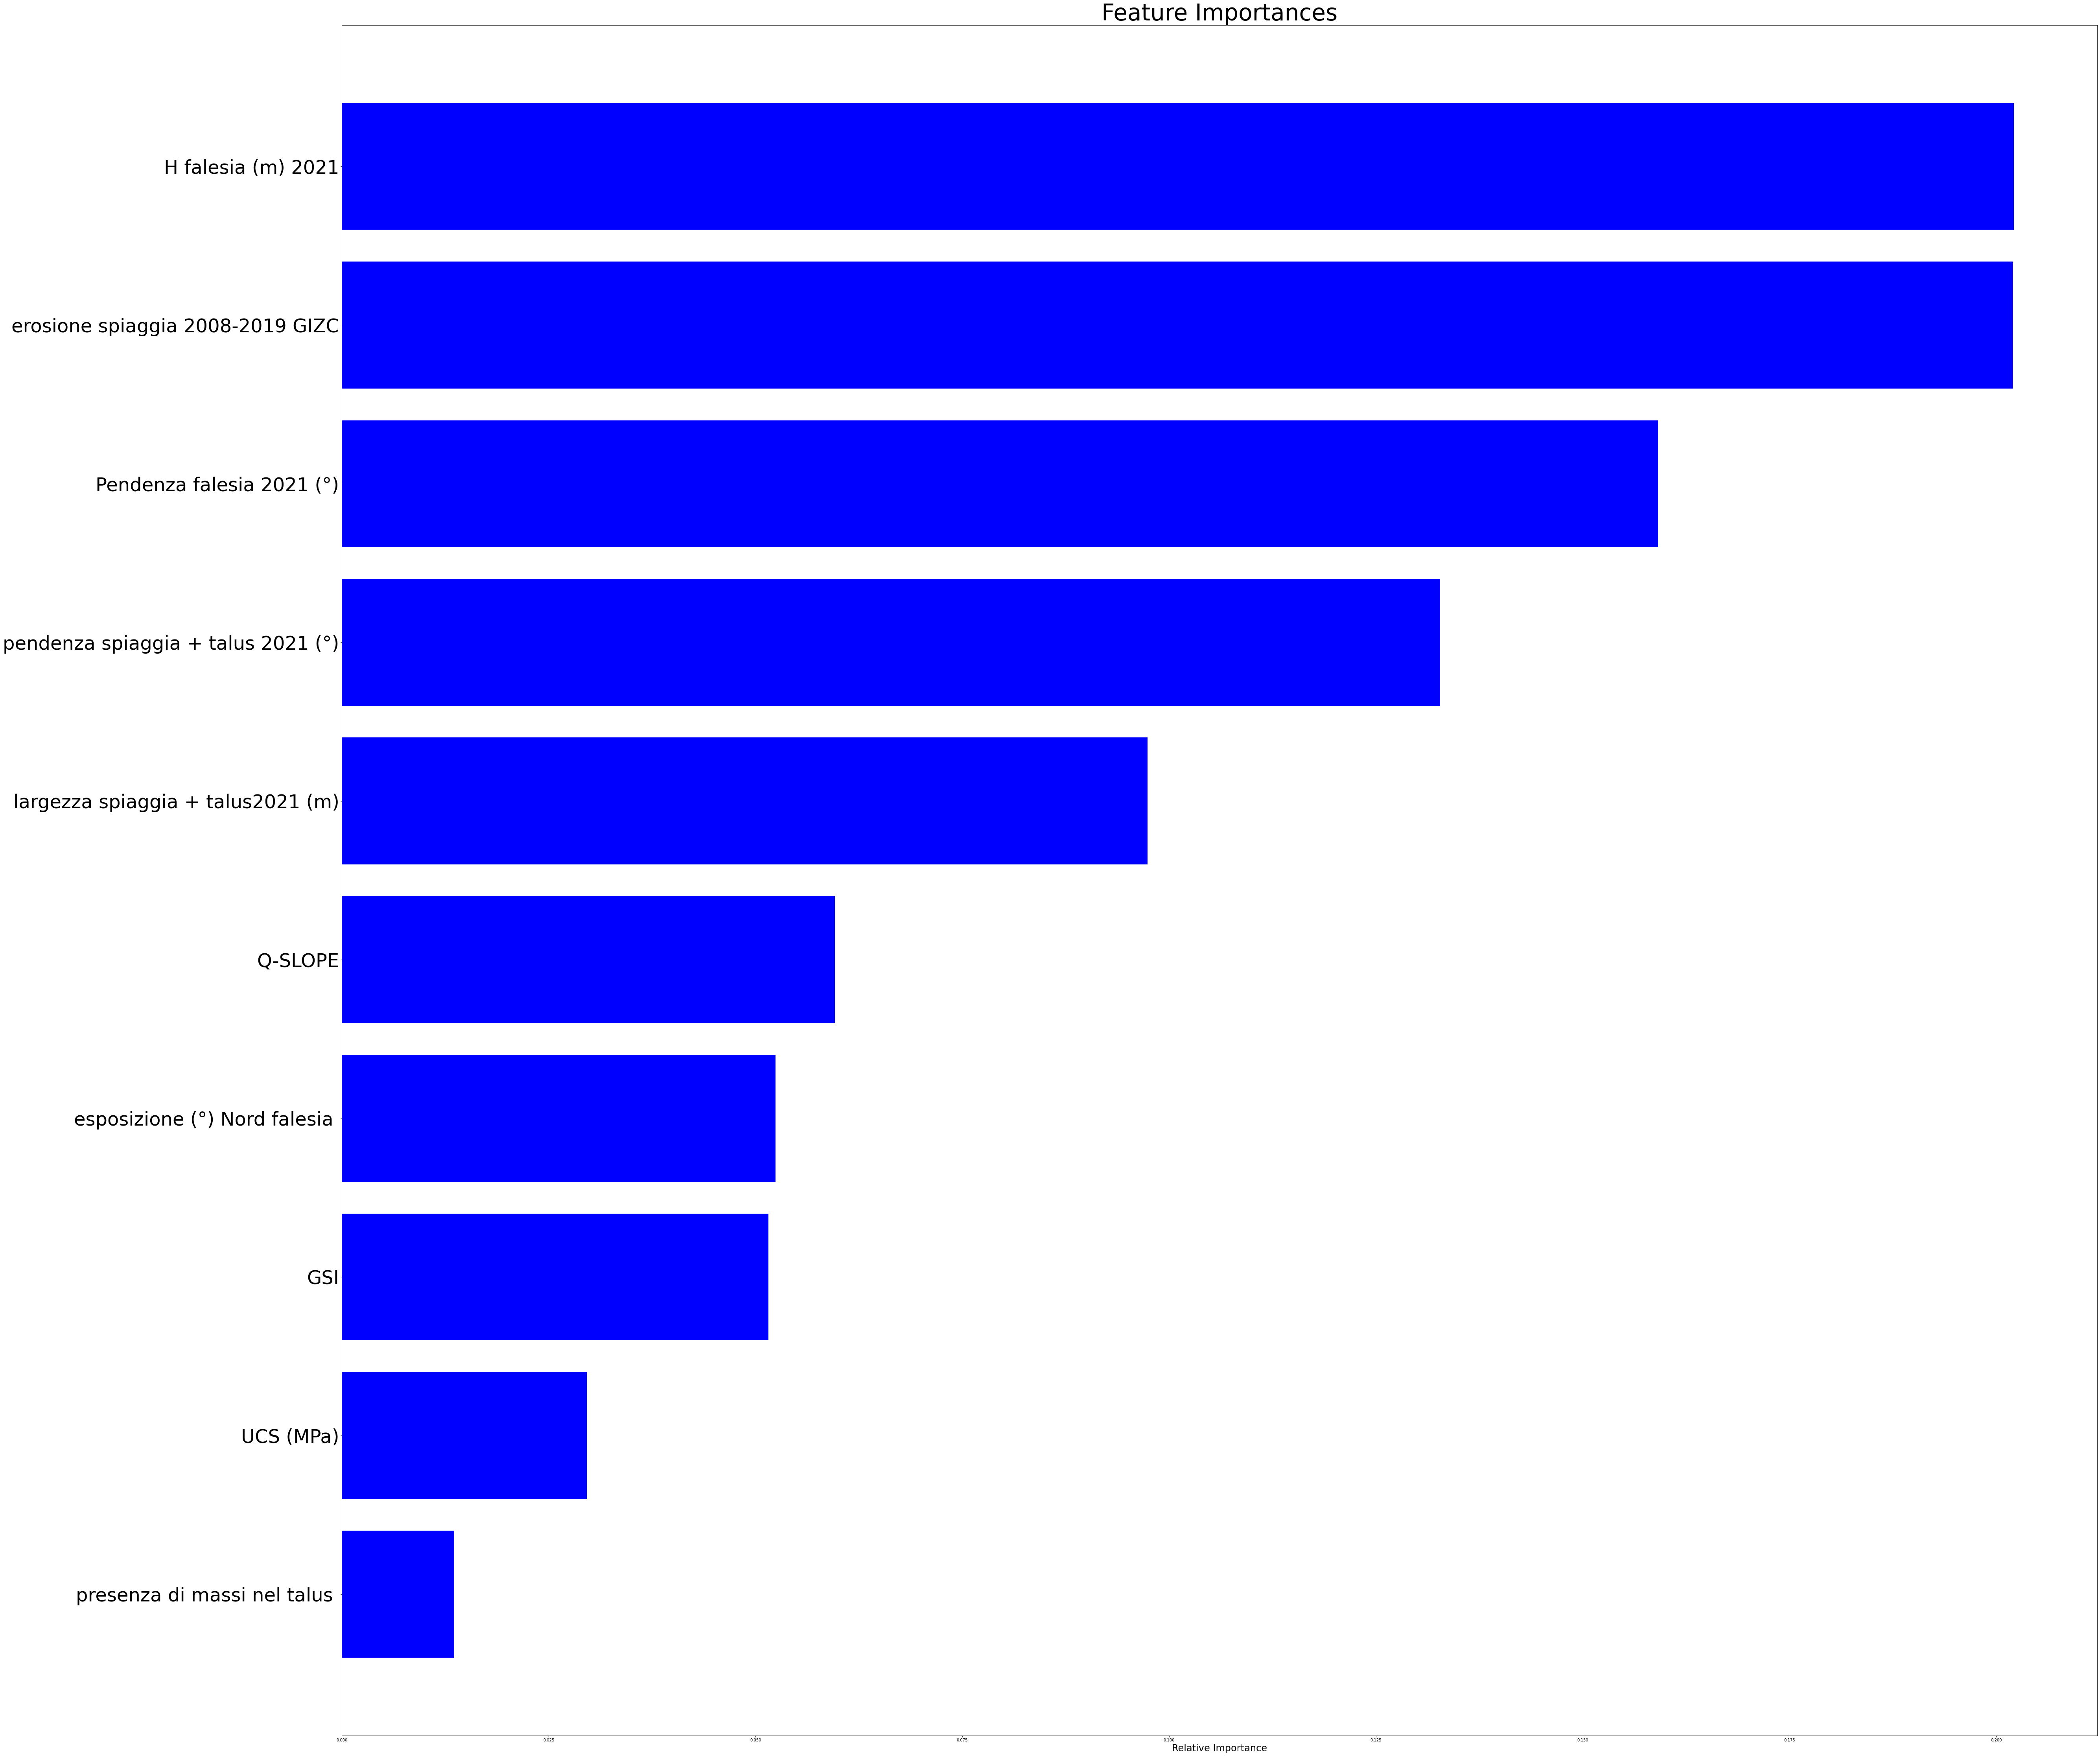

In [26]:
f_i = plot_feature_importances(est, features, "feature_importance.png")

##### Results
Score best parameters:  0.8705615060045439
Best parameters:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 150}
Test Score:  0.8181818181818182
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.86      0.67      0.75        18
           2       0.92      0.92      0.92        13

    accuracy                           0.82        44
   macro avg       0.83      0.84      0.82        44
weighted avg       0.83      0.82      0.82        44

Time elapsed:  467.0885400772095


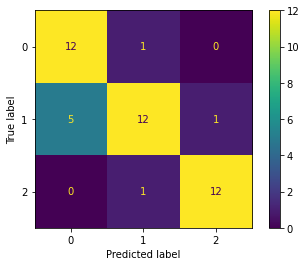

In [29]:
xgb_grid = {
    "learning_rate": [0.1, 0.2, 0.3, 0.05, 0.4],
    "max_depth": [3, 4, 5, 6, 7, 8, 9],
    "n_estimators": [50, 100, 130, 150]
}


clf1 = GradientBoostingClassifier()
res, est = hyperparameter_optimization(
    clf1, xgb_grid, X_train, y_train, X_test, y_test, 'grid_search')


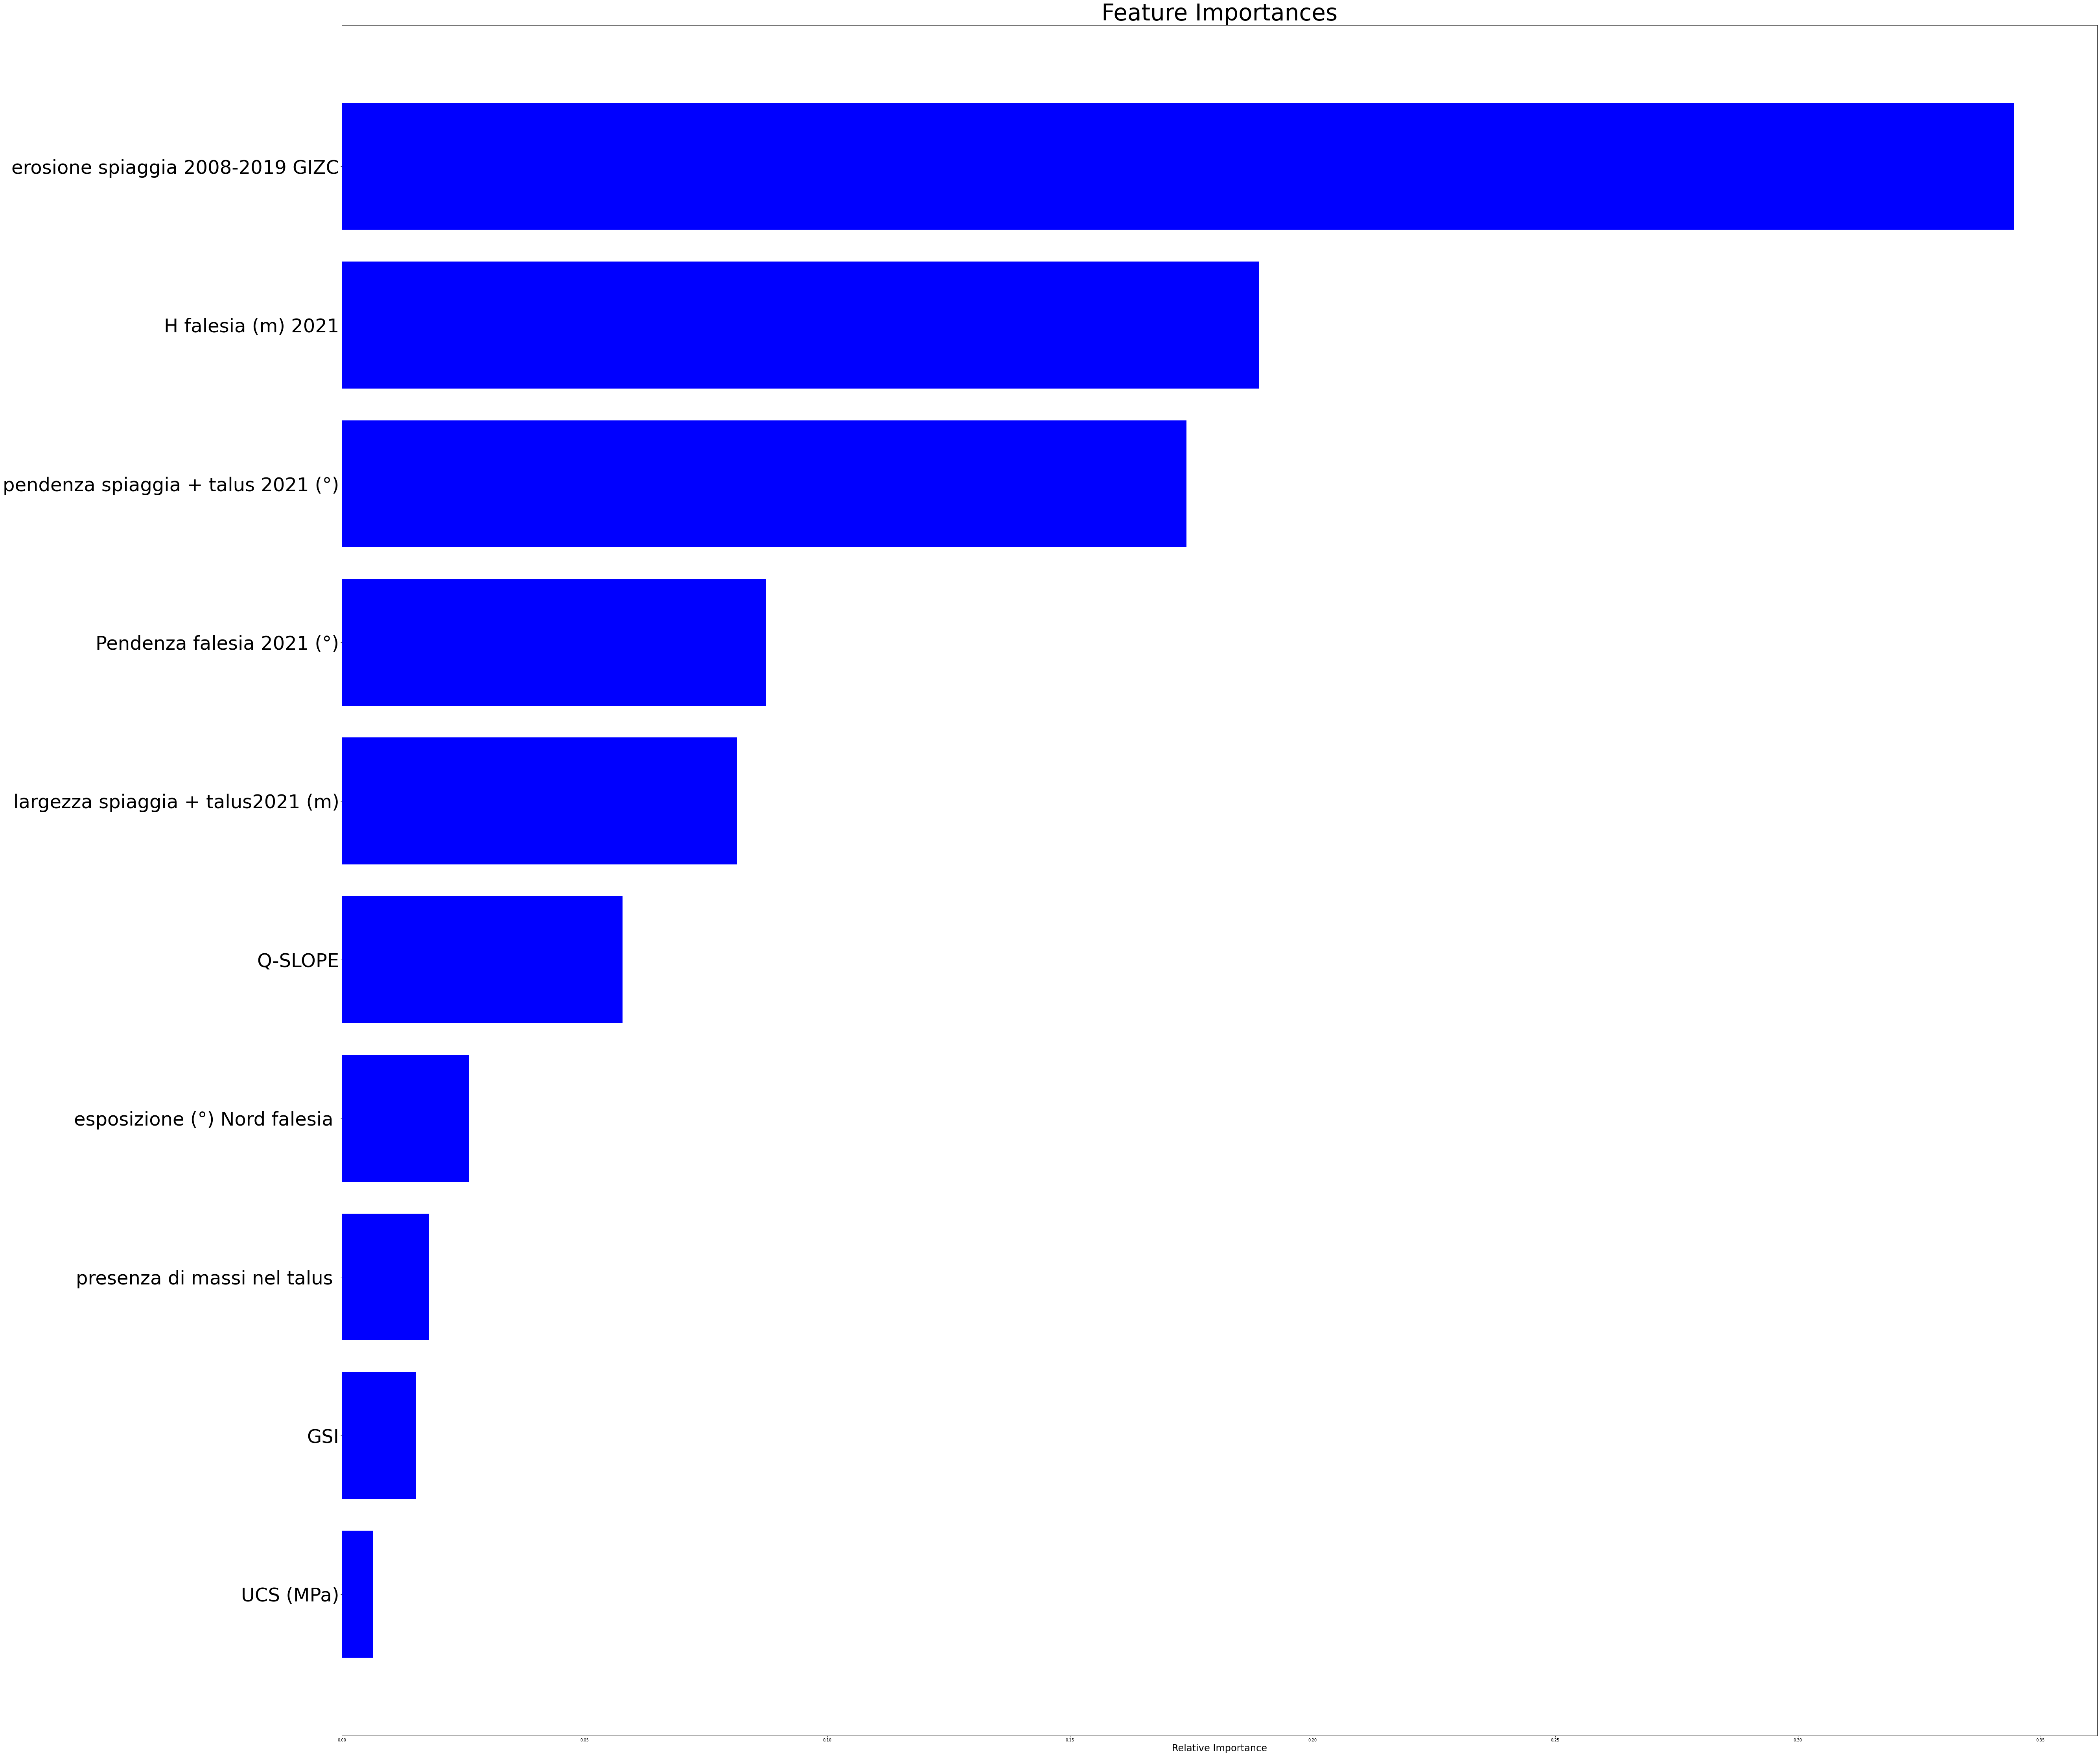

In [28]:
f_i = plot_feature_importances(est, features, "feature_importance.png")
